Подключим Keras и все необходимые нам модули

In [1]:
import keras
from keras import applications
from keras.utils.vis_utils import model_to_dot
from keras.applications import imagenet_utils
from keras import backend as K
import numpy as np
import tensorflow as tf

/home/aminov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from skimage.transform import  resize

In [3]:
from imageio import imread, imwrite

In [4]:
sess = K.get_session()
sess.as_default()

In [5]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

В модуле applications вы сможете найти большое количество предтренированных моделей. Загрузим уже знакомый нам VGG16, обученный на Imagenet

In [879]:
# build the VGG16 network
K.clear_session()
model = applications.VGG16(include_top=True, weights='imagenet')#

В Keras существуют удобные средства для визуализации моделей. 

In [880]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [936]:
image = imread('inop.jpg')#https://distill.pub/2017/feature-visualization/

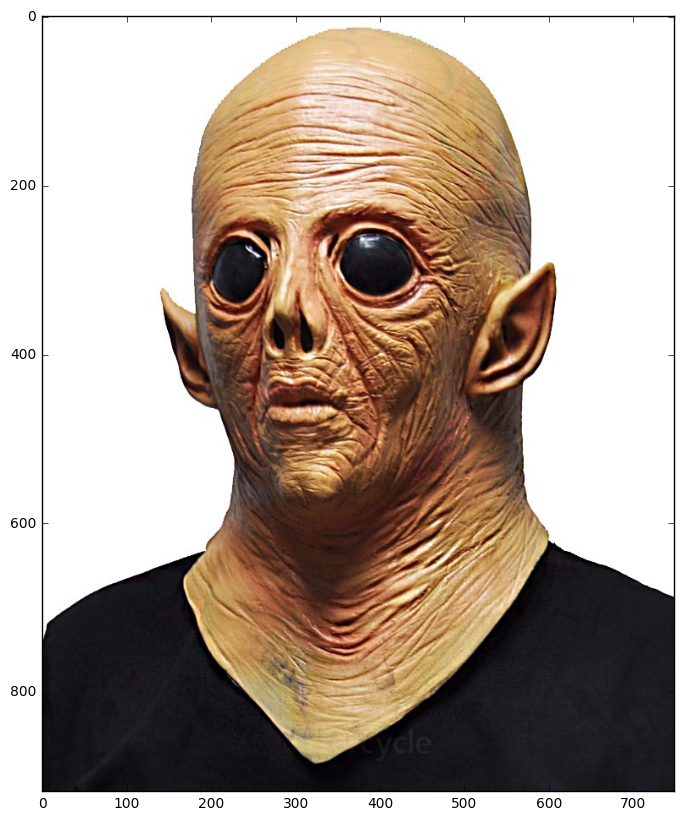

In [937]:
plt.imshow(image)

In [938]:
resized_image = resize(image, (224, 224), mode='wrap', preserve_range=True)
y = model.predict(np.expand_dims(resized_image, 0))

In [939]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [940]:
imagenet_utils.decode_predictions(y)

[[('n03724870', 'mask', 0.9728439),
  ('n04229816', 'ski_mask', 0.016772851),
  ('n02807133', 'bathing_cap', 0.003018061),
  ('n04584207', 'wig', 0.002614087),
  ('n03424325', 'gasmask', 0.0012174826)]]

In [982]:
# def build_train_function(class_index = 0):
#     # Получаем тензор, отвечающий за вход модели
#     input_img = model.input
        
#     # Выберем нужный слой
#     predictions = model.output #model.layers[-1].output model.output
#     probabilities = K.softmax(predictions)
#     objective = K.log(probabilities + 1e-8)[:,class_index]
    
#     # Вызываем метод бэкенда, рассчитывающий градиент
#     grads = K.gradients(objective, input_img)[0]

#     # Оборачиваем всё это в специальную абстракцию,
#     # которая скрывает вызов сессии TF
#     return K.function([input_img], [grads, objective])



def build_train_function(class_index = 0):
    
    input_img = model.input
    soutput = K.relu(model.layers[-1].output)  #model.output
    grads = K.gradients(soutput[:,class_index]+ 1e-8, input_img)[0] # [:,class_index]+ 1e-8
    return K.function([input_img],[grads])


In [983]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [984]:
# def compute_image(train_function, img, max_iter = 250, lr = 1, epsilon = 5.0, n=1e-8):
#     input_img_data = img.copy()
    
#     below = img - epsilon
#     above = img + epsilon
    
#     for i in range(max_iter):
#         grads_value, objective_value = train_function([input_img_data])
#         grads_value /= grads_value.std()+n   
#         input_img_data += grads_value * lr
#         input_img_data = np.clip(np.clip(input_img_data, below, above), 0, 255)
# #         input_img_data = np.clip(np.clip(input_img_data, input_img_data, input_img_data), 0, 255)
        
#         print(f'objective: {np.mean(objective_value):.2}', end='\r')
    
#     input_img_data = input_img_data[0]
#     return input_img_data.astype(np.uint8)



def compute_image(train_function, img, max_iter = 250, lr = 1, epsilon = 5.0, n=1e-8):
    input_img_data = img.copy()
    
    below = img - epsilon
    above = img + epsilon
    
    for i in range(max_iter):
        grads_value = train_function([input_img_data])
        
        grads_value = np.array(grads_value[0])
        
#         input_img_data = grads_value
        grads_value /= grads_value.std() 
        input_img_data += grads_value * lr
        input_img_data = np.clip(np.clip(input_img_data, below, above), 0, 255)
        
#         print(f'objective: {np.mean(objective_value):.2}', end='\r')
    
    input_img_data = input_img_data[0]
    return input_img_data.astype(np.uint8)


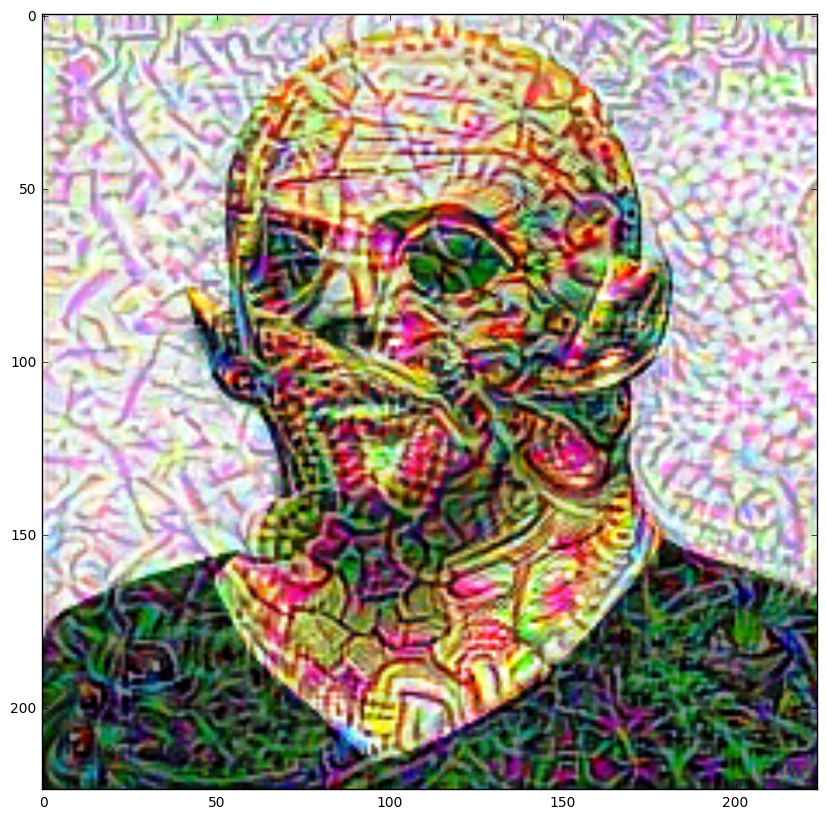

In [990]:
train_function = build_train_function(774)
img = compute_image(train_function, lr=12.1, max_iter = 50, img = np.expand_dims(resized_image, 0), epsilon=120
                    , n=1e-14)
plt.imshow(img)

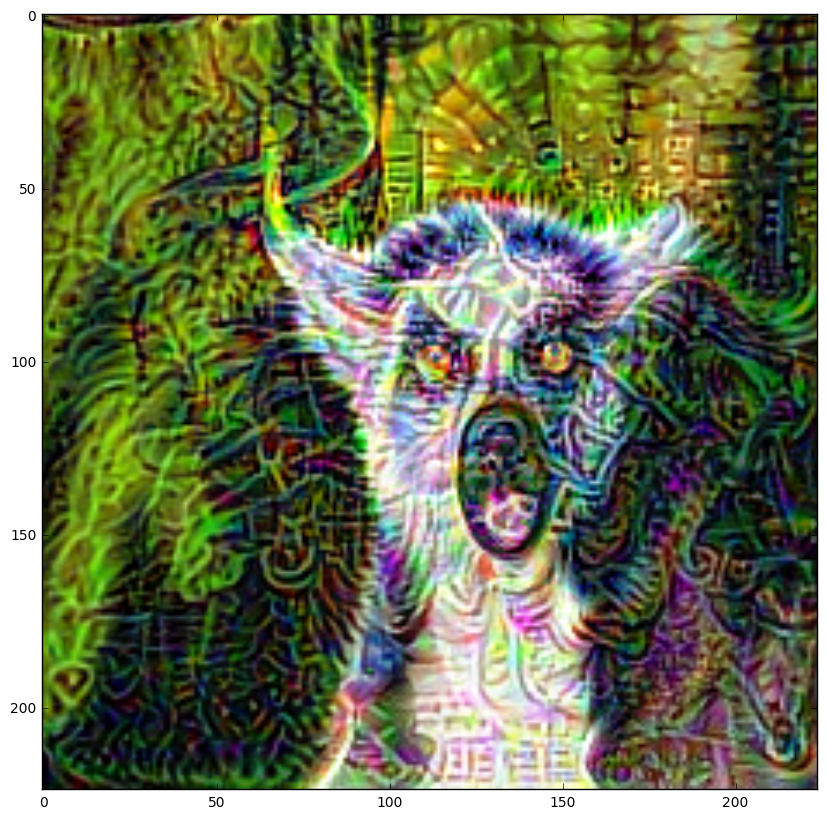

In [794]:
train_function = build_train_function(345)
img = compute_image(train_function, lr=10.1, max_iter = 50, img = np.expand_dims(resized_image, 0), epsilon=99
                    , n=1e-14)
plt.imshow(img)

In [388]:
for i in range(0,20):
    train_function = build_train_function(77)
    img = compute_image(train_function, lr=1.1, max_iter = 50, img= np.expand_dims(resized_image, 0), epsilon=i
                        , n=1e-8)
    plt.imshow(img)
    plt.show()

KeyboardInterrupt: 

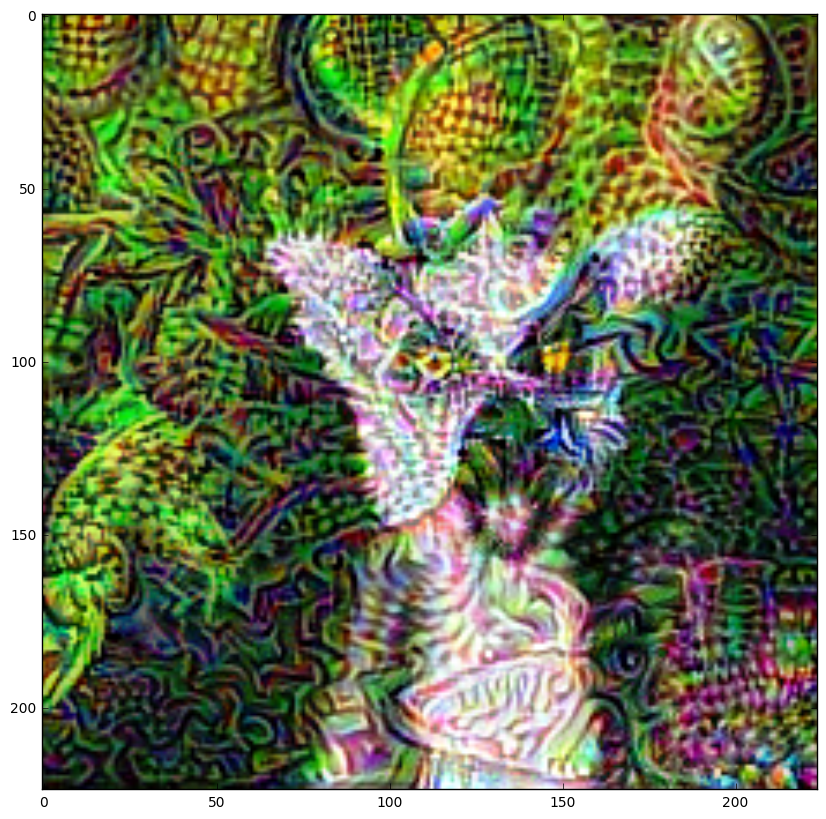

In [286]:
train_function = build_train_function(77)
img = compute_image(train_function, lr=10.1, max_iter = 50, img= np.expand_dims(resized_image, 0), epsilon=99
                    , n=1e-998)
plt.imshow(img)

In [649]:
y = model.predict(np.expand_dims(img, 0))
imagenet_utils.decode_predictions(y)

[[('n01775062', 'wolf_spider', 0.99999964),
  ('n01773549', 'barn_spider', 2.0951076e-07),
  ('n01774750', 'tarantula', 6.7927175e-08),
  ('n02231487', 'walking_stick', 3.3503852e-08),
  ('n01980166', 'fiddler_crab', 2.257138e-08)]]

In [22]:
from scipy.ndimage.interpolation import shift, rotate

In [23]:
rotated = rotate(img, np.degrees(np.pi/8), reshape=False)

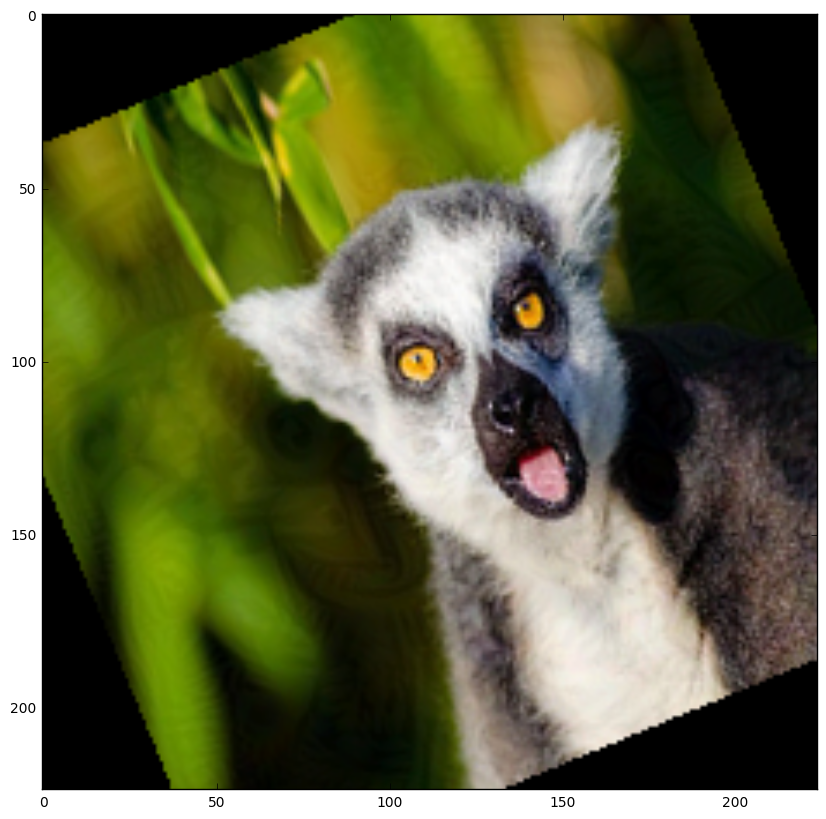

In [36]:
plt.imshow(rotated)

In [37]:
y = model.predict(np.expand_dims(rotated, 0))
imagenet_utils.decode_predictions(y)

[[('n02500267', 'indri', 0.30642506),
  ('n02123597', 'Siamese_cat', 0.28295314),
  ('n02497673', 'Madagascar_cat', 0.14908265),
  ('n02493509', 'titi', 0.09567029),
  ('n02124075', 'Egyptian_cat', 0.020687232)]]

In [38]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [39]:
def build_train_function_robust(class_index = 0, num_samples = 20):
    # Получаем тензор, отвечающий за вход модели
    input_img = K.placeholder(shape=(1, 224,224,3))
            
    objectives = []
    for _ in range(num_samples):
        angle = K.random_uniform((), minval=-np.pi/4, maxval=np.pi/4)
        rotated = tf.contrib.image.rotate(input_img, angles=angle)
        output = model(rotated)
        probabilities = K.softmax(output)
        neg_xent = K.log(probabilities + 1e-8)[:,class_index]
        objectives.append(neg_xent)
        
    
    objective = K.mean(neg_xent)
    
    # Вызываем метод бэкенда, рассчитывающий градиент
    grads = K.gradients(objective, input_img)[0]

    # Оборачиваем всё это в специальную абстракцию,
    # которая скрывает вызов сессии TF
    return K.function([input_img], [grads, objective])

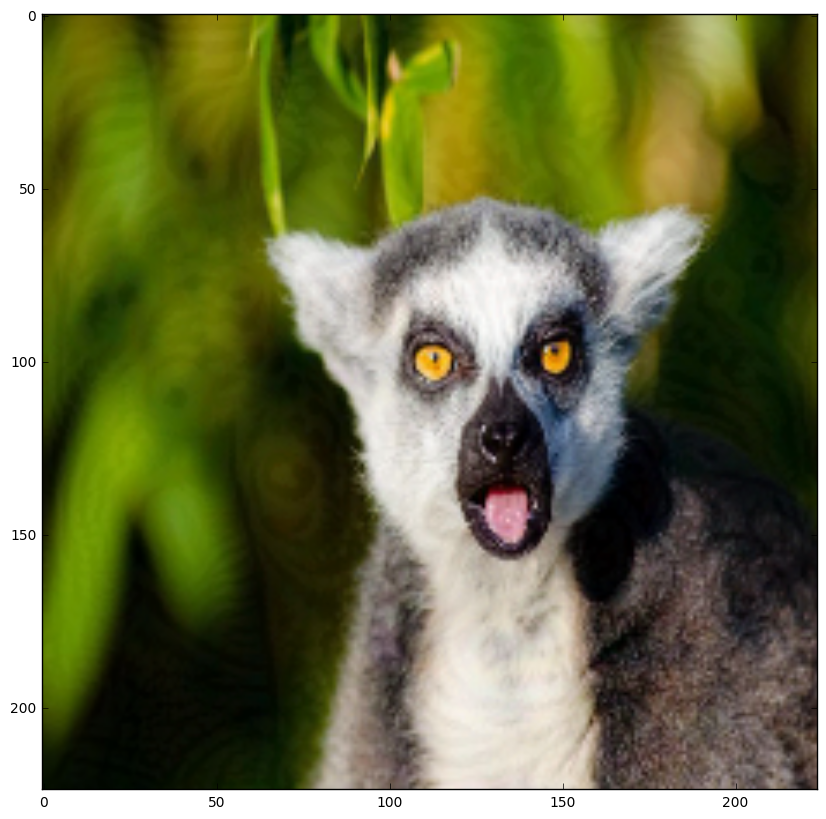

In [40]:
train_function = build_train_function_robust(965)
img = compute_image(train_function, lr=1, img= np.expand_dims(resized_image, 0), epsilon=3.5)
plt.imshow(img)

In [41]:
y = model.predict(np.expand_dims(img, 0))
imagenet_utils.decode_predictions(y)

[[('n02497673', 'Madagascar_cat', 0.11276912),
  ('n04074963', 'remote_control', 0.08168738),
  ('n02500267', 'indri', 0.03842776),
  ('n07880968', 'burrito', 0.03147422),
  ('n04209133', 'shower_cap', 0.031032367)]]

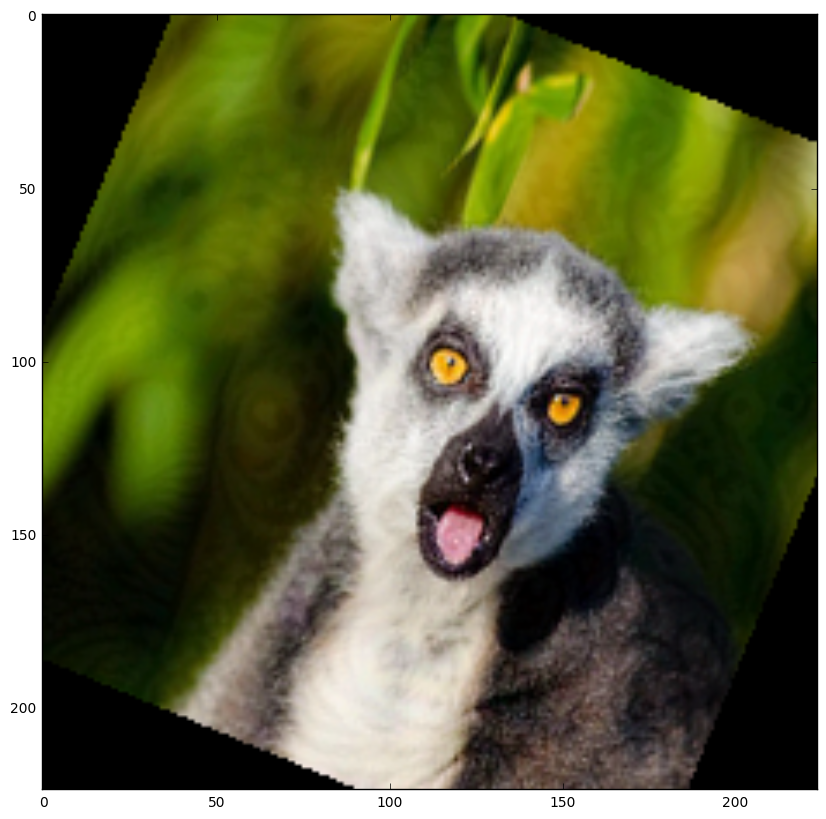

In [42]:
rotated = rotate(img, - np.degrees(np.pi/8), reshape=False)
plt.imshow(rotated)

In [43]:
y = model.predict(np.expand_dims(rotated, 0))
imagenet_utils.decode_predictions(y)

[[('n07880968', 'burrito', 0.864571),
  ('n02088632', 'bluetick', 0.021462776),
  ('n03887697', 'paper_towel', 0.010797839),
  ('n04209133', 'shower_cap', 0.009620866),
  ('n04074963', 'remote_control', 0.0072390777)]]